In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc_1 = nn.Linear(28*28*1, 64)
        self.fc_2 = nn.Linear(64, 128)
        self.fc_3 = nn.Linear(128, 10)

    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = F.relu(self.fc_1(out))
        out = F.relu(self.fc_2(out))
        out = self.fc_3(out)

        return out

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(7 * 7 * 64, 200)
        self.relu3 = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(200, 10)

    def forward(self, x):
        out = self.maxpool1(self.relu1(self.conv1(x)))
        out = self.maxpool2(self.relu2(self.conv2(out)))
        out = out.view(out.size(0), -1)
        out = self.relu3(self.linear1(out))
        out = self.linear2(out)
        return out

In [4]:
gen_model = MLP()
model = LeNet()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

gen_model.to(device)
model.to(device)

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3136, out_features=200, bias=True)
  (relu3): ReLU(inplace=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
)

# Try 1: Untrained network with random initialization for perturbed image generation

In [21]:
# # Download F-MNIST dataset
# transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
#
# train_set = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transf, download=True)
# test_set = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transf, download=True)
#
# dataset = {
#     "trainset": train_set,
#     "testset": test_set
# }
# torch.save(dataset, "data/FashionMNIST/dataset.pt")

dataset = torch.load("data/FashionMNIST/dataset.pt")

train_set = dataset["trainset"]
test_set = dataset["testset"]

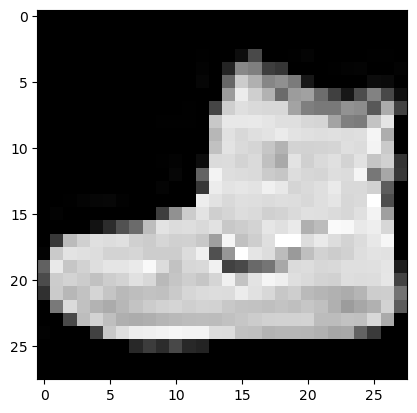

In [41]:
plt.imshow(np.moveaxis(train_set[0][0].detach().cpu().numpy(), 0, 2), cmap='gray')

### Generate perturbed images

In [49]:
from advertorch.attacks import LinfPGDAttack

adversary = LinfPGDAttack(
    gen_model,
    loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=2.0,
    nb_iter=3,
    eps_iter=1.0,
    rand_init=True,
    clip_min=0.0,
    clip_max=1.0,
    targeted=False
)

In [50]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
aux_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

In [52]:
for cln_data, true_label in aux_loader:
    break

cln_data, true_label = cln_data.to(device), true_label.to(device)

pgd_untargeted = adversary.perturb(cln_data, true_label)

# Only untargeted for now
# target = torch.ones_like(true_label)*4
# adversary.targeted = True
# pgd_targeted = adversary.perturb(cln_data, target)

In [53]:
pgd_data = torch.utils.data.TensorDataset(pgd_untargeted, true_label)

perturb_loader = DataLoader(
    dataset=pgd_data,
    batch_size=64,
    shuffle=False
)

### Train

In [54]:
def epoch(mode, dev, net, dataloader, optimizer, criterion):
    loss_avg, acc_avg, num_exp = 0,0,0
    if mode == "train":
        net.train()

    else:
        net.eval()

    for i, data in enumerate(dataloader):
        imgs, labels = data
        imgs = imgs.to(dev)
        labels = labels.to(dev)

        n_b = labels.shape[0]

        outputs = net(imgs)
        loss = criterion(outputs, labels)

        acc = np.sum(np.equal(np.argmax(outputs.cpu().data.numpy(), axis=-1), labels.cpu().data.numpy()))

        loss_avg += loss.item()
        acc_avg += acc
        num_exp += n_b

        if mode == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    loss_avg /= num_exp
    acc_avg /= num_exp

    return loss_avg, acc_avg

In [55]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [56]:
for e in range(10):
    train_loss, train_acc = epoch("train", device, model, train_loader, optimizer, criterion)
    print(f"[{e + 1}] TRAINING \n loss: {train_loss:.3f}, accuracy: {train_acc:.3f}")

    test_loss, test_acc = epoch("test", device, model, test_loader, optimizer, criterion)
    print(f"[{e + 1}] TESTING \n loss: {test_loss:.3f}, accuracy: {test_acc:.3f}")

    test_loss, test_acc = epoch("test", device, model, perturb_loader, optimizer, criterion)
    print(f"[{e + 1}] PERTURBATION \n loss: {test_loss:.3f}, accuracy: {test_acc:.3f}")

[1] TRAINING 
 loss: 0.008, accuracy: 0.809
[1] TESTING 
 loss: 0.006, accuracy: 0.859
[1] PERTURBATION 
 loss: 0.085, accuracy: 0.106
[2] TRAINING 
 loss: 0.005, accuracy: 0.873
[2] TESTING 
 loss: 0.006, accuracy: 0.859
[2] PERTURBATION 
 loss: 0.099, accuracy: 0.079
[3] TRAINING 
 loss: 0.005, accuracy: 0.884
[3] TESTING 
 loss: 0.006, accuracy: 0.858
[3] PERTURBATION 
 loss: 0.097, accuracy: 0.086
[4] TRAINING 
 loss: 0.005, accuracy: 0.889
[4] TESTING 
 loss: 0.005, accuracy: 0.879
[4] PERTURBATION 
 loss: 0.097, accuracy: 0.086
[5] TRAINING 
 loss: 0.005, accuracy: 0.891
[5] TESTING 
 loss: 0.005, accuracy: 0.879
[5] PERTURBATION 
 loss: 0.125, accuracy: 0.097
[6] TRAINING 
 loss: 0.004, accuracy: 0.897
[6] TESTING 
 loss: 0.005, accuracy: 0.880
[6] PERTURBATION 
 loss: 0.089, accuracy: 0.121
[7] TRAINING 
 loss: 0.004, accuracy: 0.897
[7] TESTING 
 loss: 0.005, accuracy: 0.888
[7] PERTURBATION 
 loss: 0.163, accuracy: 0.118
[8] TRAINING 
 loss: 0.004, accuracy: 0.900
[8] TESTING